In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("/root/clip")
import torch
import matplotlib.pyplot as plt

from clipmbt.augment.augment import MultimodalAugment
from clipmbt.augment.specaugment import Specaugment
from clipmbt.data.data_loading import Collate_Constrastive, CollateContrastiveMSP, load_data, Collate_Constrastive_NeutralAware, load_data_neutral_aware
from clipmbt.datasets import enterface, tess, mspodcast
from clipmbt.constants import *
from clipmbt.face import get_roi_patch, get_roi_presets


def image_grid(rgb_batch=None, spec_batch=None):
    assert (rgb_batch is not None) or (spec_batch is not None), "rgb_batch or spec_batch must be present, both cannot be empty!"
    rgb_img_grid = None
    spec_img_grid = None
    if rgb_batch is not None:
        batch_sz, chans, frames, height, width = rgb_batch.shape
        rgb_copy = rgb_batch.clone().permute(2, 3, 0, 4, 1)
        rgb_img_grid = rgb_copy.reshape(height*frames, width*batch_sz, chans)

    if spec_batch is not None:
        spec_batch = spec_batch.permute(0, 2, 1)
        batch_sz, height, width = spec_batch.shape
        spec_copy = spec_batch.clone()
        spec_img_grid = spec_copy.reshape(height * batch_sz, width, 1)
    
    if (rgb_img_grid is not None) and (spec_img_grid is not None):
        img_grid = torch.vstack((spec_img_grid, rgb_img_grid))
    else:
        img_grid = rgb_img_grid if rgb_img_grid is not None else spec_img_grid
    return img_grid


def show_batch(rgb_batch=None, spec_batch=None, title="Image batch", size=5):
    result = image_grid(rgb_batch, spec_batch)
    fig = plt.figure(figsize=(size, size))
    plt.suptitle(f"{title}")
    plt.imshow(result, interpolation="nearest")

tensor([[5.2000, 1.8000, 5.6000],
        [5.4000, 5.0000, 5.8000],
        [3.4000, 2.2000, 3.6000],
        [4.8000, 5.2000, 4.2000],
        [4.0000, 4.0000, 4.0000]])
torch.Size([5, 1])


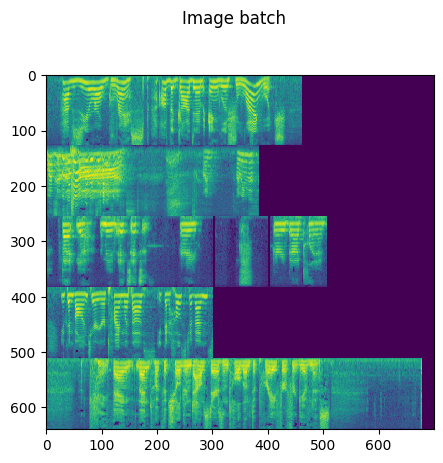

In [50]:
ds_to_use = mspodcast
# augmentor = MultimodalAugment(enterface)
augmentor = Specaugment(tmask_param=40, fmask_param=40)
collate_fn = CollateContrastiveMSP(ds_to_use, augmentor=augmentor)
# collate_fn = Collate_Constrastive_NeutralAware(tess, augmentor=None)

train_dl, val_dl, test_dl, split_seed  = load_data(ds_to_use, 
                                    batch_sz=5,
                                    train_val_test_split=SPLIT,
                                    seed=None,
                                    train_collate_func=collate_fn,
                                    val_collate_func=collate_fn,
                                    leave_speaker_out=None)

train_batch = next(iter(train_dl))
# val_batch = next(iter(val_dl))
# clip0_rgb, clip0_spec = train_batch["clip1"]
train_labels = train_batch["labels"]
act_val_dom = train_batch["act_val_dom"]
print(act_val_dom)
# val_labels = val_batch["labels"]
# print(val_labels)

print(train_labels.shape)
spec, spec_aug = train_batch["audios"], train_batch["audios_aug"]
# print(clip0_rgb.shape, clip0_spec.shape)
show_batch(None, spec)

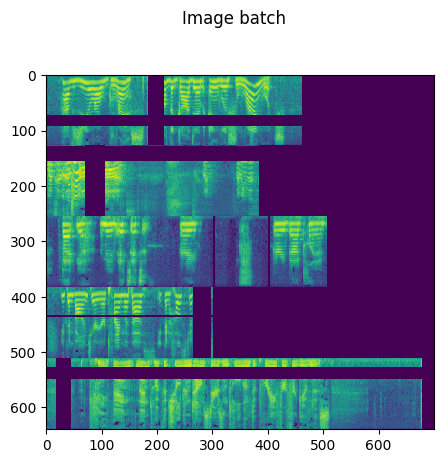

In [51]:
show_batch(None, spec_aug)

In [ ]:
import torch.nn as nn
from clipmbt.resnet.resnet import SimpleCNN
from torch.nn.utils.rnn import pad_sequence as pseq
from clipmbt.jepa.pos_embs import get_1d_sincos_pos_embed
from clipmbt.open_clip.transformer import Transformer


presets  = get_roi_presets(HEIGHT, WIDTH)
clip0_rgb_roi_close_face = get_roi_patch(clip0_rgb, **presets["close_face"])
clip0_rgb_roi_forehead = get_roi_patch(clip0_rgb, **presets["forehead"])
clip0_rgb_roi_eyebrows = get_roi_patch(clip0_rgb, **presets["eyebrows"])
clip0_rgb_roi_eyes_nose = get_roi_patch(clip0_rgb, **presets["eyes_nose"])
clip0_rgb_roi_nose_mouth = get_roi_patch(clip0_rgb, **presets["nose_mouth"])
# show_batch(clip0_rgb_roi, size=20)
scnn = SimpleCNN(3)
simple_tfm = Transformer(1536, 12, 8)

# batch = torch.flatten(clip0_rgb_roi_close_face, start_dim=0, end_dim=1)
r1 = scnn(clip0_rgb_roi_forehead).permute(2, 1, 0)
r2 = scnn(clip0_rgb_roi_eyebrows).permute(2, 1, 0)
r3 = scnn(clip0_rgb_roi_close_face).permute(2, 1, 0)
r4 = scnn(clip0_rgb_roi_eyes_nose).permute(2, 1, 0)
r5 = scnn(clip0_rgb_roi_nose_mouth).permute(2, 1, 0)

out_ = pseq([r1, r2, r3, r4, r5]).permute(3, 2, 1, 0)
out__ = out_.flatten(start_dim=1, end_dim=2)

cls_token = nn.Parameter(torch.zeros(1, 1, 1536)).expand((3, -1, -1))
pos_embed_ui = nn.Parameter(torch.zeros(1, 80 + 1, 1536))

out = torch.cat((cls_token, out__), dim=1)
sincos1d = get_1d_sincos_pos_embed(1536, 80, cls_token=True)
pos_embed = pos_embed_ui.data.copy_(torch.from_numpy(sincos1d))


print(out.shape)# each one of the 80 tokens represents a single region in a single frame in a single video
                # each video therefore has 80 tokens representing both facial and temporal regions of the 
                # input 
inp = out + pos_embed
print(inp.shape)
tfm_out = simple_tfm(inp)
print(tfm_out.shape)
# print(r1.shape)
# print(r2.shape)
# print(r3.shape)
# print(r4.shape)
# print(r5.shape)